Plot maps and time series of SM daily mean and variability
for several simulation setups

In [2]:
import sys
import os
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import BoundaryNorm

from config import KSCALEFIGDIR
from p_config import regions
from read_data import *

In [3]:
season='winter'
driving='GAL9'
region='africa'  # 'sea'  # 'samerica'
resolution='km4p4'
physics='RAL3'
depth=0  # soil layer [0, 3]

year = 2020
dates = {2: np.arange(1, 28+1, 1)}  # 1: np.arange(20, 30+1, 1), -> REMOVE first 10-day (spin-up?)

proj = ccrs.PlateCarree()

lat_range = regions[region][0]
lon_range = regions[region][1]
lat_min = lat_range[0]
lat_max = lat_range[1]
lon_min = lon_range[0]
lon_max = lon_range[1]

if region == 'sea':  # for time series plot at grid point
    lat_pt = 20.
    lon_pt = 100.
else:
    lat_pt = (lat_range[1] - lat_range[0]) / 2 + lat_range[0]
    lon_pt = (lon_range[1] - lon_range[0]) / 2 + lon_range[0]
(lat_pt, lon_pt)

xtcks = np.arange(lon_range[0], lon_range[1]+10, 10)
ytcks = np.arange(lat_range[0], lat_range[1]+10, 10)

if region == 'africa':  # text location on maps
    xtxt = 0.025
    ytxt = 0.025
else:
    xtxt = 0.55
    ytxt = 0.925

rm_window = 7  # to smooth out low-freq variability

In [4]:
#~ Figdir

if not os.path.isdir(KSCALEFIGDIR + '/' + region):
    os.mkdir(KSCALEFIGDIR + '/' + region)
figdir = KSCALEFIGDIR + '/' + region

if not os.path.isdir(figdir + '/depth=' + str(depth)):
    os.mkdir(figdir + '/depth=' + str(depth))
figdir = figdir + '/depth=' + str(depth)

figfile = figdir + '/timeseries.pdf'
figfile_pt = figdir + '/timeseries_point.pdf'

figfile_maps_mean = figdir + '/maps_mean.pdf'
#figfile_maps = figdir + '/maps.pdf'
figfile_maps_var_ano = figdir + '/maps_var_ano.pdf'

figfile_spat_std = figdir + '/spatial_var.pdf'

figdir

'/home/users/guicha/Pythons/KSCALE/outputs/figures/africa/depth=0'

In [5]:
#~ Get data

out_data_glo = []
out_data_cha = []
out_data_lam = []

for month, days in dates.items():
    print('\no %i'%month)
    for day in days:
        print(day, end=' : ', flush=True)

        data_lam = load_data_lam_smc(season, driving, region, resolution, physics, year, month, day, (lat_min, lat_max), (lon_min, lon_max), depth)
        data_glo = load_data_global_smc(season, driving, 'n1280', 'GAL9', year, month, day, (lat_min, lat_max), (lon_min, lon_max), depth)
        data_cha = load_data_channel_smc(season, driving, resolution, physics, year, month, day, (lat_min, lat_max), (lon_min, lon_max), depth)

        out_data_glo.append(data_glo)
        out_data_cha.append(data_cha)
        out_data_lam.append(data_lam)

out_data_glo = xr.concat(out_data_glo, dim='time')
out_data_cha = xr.concat(out_data_cha, dim='time')
out_data_lam = xr.concat(out_data_lam, dim='time')


o 2
1 : 2 : 3 : 4 : 5 : 6 : 7 : 8 : 9 : 10 : 11 : 12 : 13 : 14 : 15 : 16 : 17 : 18 : 19 : 20 : 21 : 22 : 23 : 24 : 25 : 26 : 27 : 28 : 

In [24]:
#~ Plot snapshots

data_lam_mean = data_lam.mean(dim='time')
data_lam_space = data_lam_mean.stack(space=('latitude', 'longitude'))
data_lam_std = data_lam_space.std(dim='space')

data_glo_mean = data_glo.mean(dim='time')
data_glo_space = data_glo_mean.stack(space=('latitude', 'longitude'))
data_glo_std = data_glo_space.std(dim='space')

fig, ax = plt.subplots()
data_lam_mean.plot(ax=ax)
ax.text(0.025, 0.025, '$\\sigma_{SM}$=%.2f mm'%data_lam_std, transform=ax.transAxes)
ax.set_title('lam $-$ %s'%str(data_lam.time.values[0])[:10])#

fig, ax = plt.subplots()
data_glo_mean.plot(ax=ax)
ax.text(0.025, 0.025, '$\\sigma_{SM}$=%.2f mm'%data_glo_std, transform=ax.transAxes)
ax.set_title('global $-$ %s'%str(data_lam.time.values[0])[:10])#

In [6]:
# Get daily data

out_data_glo_d = out_data_glo.resample(time='1D').mean()
out_data_cha_d = out_data_cha.resample(time='1D').mean()
out_data_lam_d = out_data_lam.resample(time='1D').mean()

#~ Get n-days rolling mean

out_glo_nd = out_data_glo_d.rolling(time=rm_window, center=True).mean()
out_cha_nd = out_data_cha_d.rolling(time=rm_window, center=True).mean()
out_lam_nd = out_data_lam_d.rolling(time=rm_window, center=True).mean()

#~ Get anomalies -> filter low-frequency variability

out_glo_ano = out_data_glo_d - out_glo_nd
out_cha_ano = out_data_cha_d - out_cha_nd
out_lam_ano = out_data_lam_d - out_lam_nd

In [7]:
#~ Get time averages -> plot maps

out_data_glo_d_time_mean = out_data_glo_d.mean(dim='time')
out_data_cha_d_time_mean = out_data_cha_d.mean(dim='time')
out_data_lam_d_time_mean = out_data_lam_d.mean(dim='time')

out_data_glo_nd_time_mean = out_glo_nd.mean(dim='time')
out_data_cha_nd_time_mean = out_cha_nd.mean(dim='time')
out_data_lam_nd_time_mean = out_lam_nd.mean(dim='time')

out_data_glo_ano_time_mean = out_glo_ano.mean(dim='time')
out_data_cha_ano_time_mean = out_cha_ano.mean(dim='time')
out_data_lam_ano_time_mean = out_lam_ano.mean(dim='time')

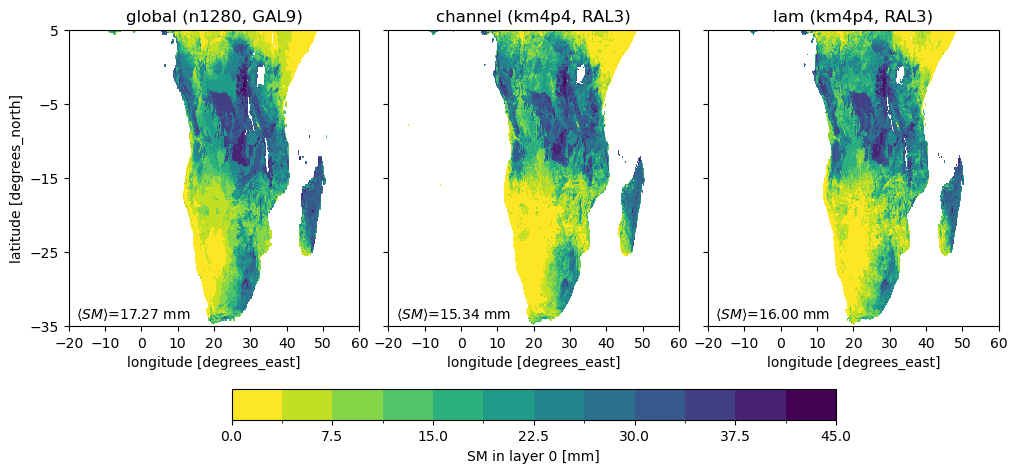

In [8]:
#~ Plot maps of mean SM

cmap = plt.get_cmap('viridis_r')

sm_min = min(out_data_glo_d_time_mean.min(), out_data_cha_d_time_mean.min(), out_data_lam_d_time_mean.min())
sm_max = max(out_data_glo_d_time_mean.max(), out_data_cha_d_time_mean.max(), out_data_lam_d_time_mean.max())

bounds = np.linspace(np.floor(sm_min), np.ceil(sm_max), 13)
norm = BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(ncols=3)

plt.subplots_adjust(wspace=0.1)

out_data_glo_d_time_mean.plot(ax=ax[0], norm=norm, cmap=cmap, add_colorbar=False)
out_data_cha_d_time_mean.plot(ax=ax[1], norm=norm, cmap=cmap, add_colorbar=False)
out_data_lam_d_time_mean.plot(ax=ax[2], norm=norm, cmap=cmap, add_colorbar=False)

ax[0].text(xtxt, ytxt, "$\\langle SM \\rangle$=%.2f mm"%out_data_glo_d_time_mean.mean(), transform=ax[0].transAxes)
ax[1].text(xtxt, ytxt, "$\\langle SM \\rangle$=%.2f mm"%out_data_cha_d_time_mean.mean(), transform=ax[1].transAxes)
ax[2].text(xtxt, ytxt, "$\\langle SM \\rangle$=%.2f mm"%out_data_lam_d_time_mean.mean(), transform=ax[2].transAxes)

ax[0].set_xticks(xtcks)
ax[0].set_yticks(ytcks)
ax[0].set_title('global (n1280, GAL9)')
ax[1].set_xticks(xtcks)
ax[1].set_yticks(ytcks)
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_title('channel (%s, %s)'%(resolution, physics))
ax[2].set_xticks(xtcks)
ax[2].set_yticks(ytcks)
ax[2].set_yticklabels([])
ax[2].set_ylabel('')
ax[2].set_title('lam (%s, %s)'%(resolution, physics))

cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[:], orientation='horizontal', label='SM in layer %i [mm]'%depth, shrink=0.65, pad=0.15)

fig.set_size_inches(12., 5.5)

fig.savefig(figfile_maps_mean)

In [9]:
#~ Get point values

glo_d_pt = out_data_glo_d.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')
glo_nd_pt = out_glo_nd.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')
glo_ano_pt = out_glo_ano.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')

cha_d_pt = out_data_cha_d.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')
cha_nd_pt = out_cha_nd.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')
cha_ano_pt = out_cha_ano.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')

lam_d_pt = out_data_lam_d.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')
lam_nd_pt = out_lam_nd.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')
lam_ano_pt = out_lam_ano.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')

sm_min = min(glo_d_pt.min(), cha_d_pt.min(), lam_d_pt.min())
sm_max = max(glo_d_pt.max(), cha_d_pt.max(), lam_d_pt.max())

ano_min = min(glo_ano_pt.min(), cha_ano_pt.min(), lam_ano_pt.min())
ano_max = max(glo_ano_pt.max(), cha_ano_pt.max(), lam_ano_pt.max())

'/home/users/guicha/Pythons/KSCALE/outputs/figures/africa/depth=0/timeseries_point.pdf'

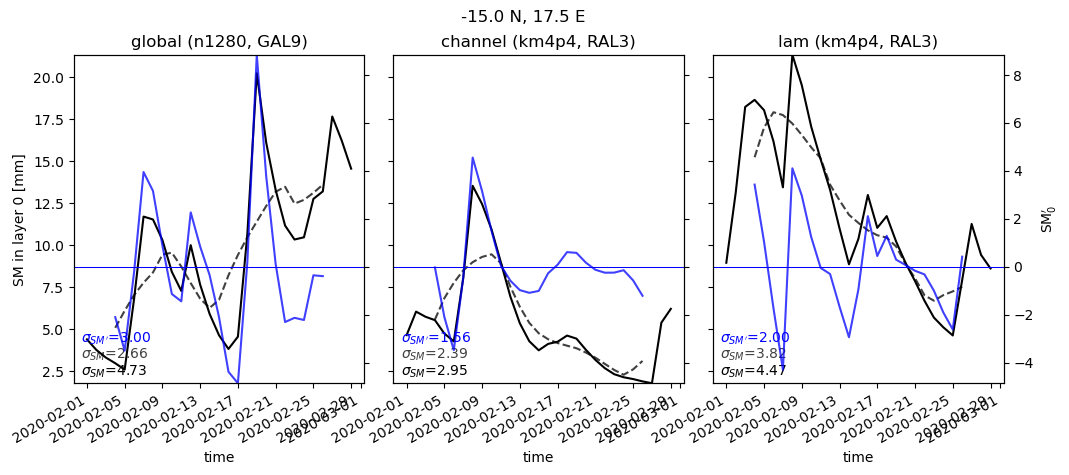

In [10]:
#~ Plot point time series

fig, ax = plt.subplots(ncols=3)

plt.subplots_adjust(bottom=0.15, wspace=0.1)

glo_d_pt.plot(ax=ax[0], color='k')
glo_nd_pt.plot(ax=ax[0], c='k', ls='--', alpha=0.75)

ax02 = ax[0].twinx()
glo_ano_pt.plot(ax=ax02, c='b', alpha=0.75)
ax02.axhline(0, 0, 1, c='b', lw=0.75)

ax[0].text(0.025, 0.025, "$\\sigma_{SM}$=%.2f"%glo_d_pt.std(), transform=ax[0].transAxes, color='k')
ax[0].text(0.025, 0.075, "$\\sigma_{SM}$=%.2f"%glo_nd_pt.std(), transform=ax[0].transAxes, color='k', alpha=0.75)
ax[0].text(0.025, 0.125, "$\\sigma_{SM'}$=%.2f"%glo_ano_pt.std(), transform=ax[0].transAxes, color='b')

cha_d_pt.plot(ax=ax[1], color='k')
cha_nd_pt.plot(ax=ax[1], c='k', ls='--', alpha=0.75)

ax12 = ax[1].twinx()
cha_ano_pt.plot(ax=ax12, c='b', alpha=0.75)
ax12.axhline(0, 0, 1, c='b', lw=0.75)

ax[1].text(0.025, 0.025, "$\\sigma_{SM}$=%.2f"%cha_d_pt.std(), transform=ax[1].transAxes, color='k')
ax[1].text(0.025, 0.075, "$\\sigma_{SM}$=%.2f"%cha_nd_pt.std(), transform=ax[1].transAxes, color='k', alpha=0.75)
ax[1].text(0.025, 0.125, "$\\sigma_{SM'}$=%.2f"%cha_ano_pt.std(), transform=ax[1].transAxes, color='b')

lam_d_pt.plot(ax=ax[2], color='k')
lam_nd_pt.plot(ax=ax[2], c='k', ls='--', alpha=0.75)

ax22 = ax[2].twinx()
lam_ano_pt.plot(ax=ax22, c='b', alpha=0.75)
ax22.axhline(0, 0, 1, c='b', lw=0.75)

ax[2].text(0.025, 0.025, "$\\sigma_{SM}$=%.2f"%lam_d_pt.std(), transform=ax[2].transAxes, color='k')
ax[2].text(0.025, 0.075, "$\\sigma_{SM}$=%.2f"%lam_nd_pt.std(), transform=ax[2].transAxes, color='k', alpha=0.75)
ax[2].text(0.025, 0.125, "$\\sigma_{SM'}$=%.2f"%lam_ano_pt.std(), transform=ax[2].transAxes, color='b')

ax[0].set_ylim(sm_min, sm_max)
ax[0].set_ylabel('SM in layer %i [mm]'%depth)
ax[0].set_title('global (n1280, GAL9)')
ax02.set_ylim(ano_min, ano_max)
ax02.set_yticklabels([])
ax02.set_title('')
ax02.set_ylabel('')

ax[1].set_ylim(sm_min, sm_max)
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_title('channel (%s, %s)'%(resolution, physics))
ax12.set_ylim(ano_min, ano_max)
ax12.set_yticklabels([])
ax12.set_title('')
ax12.set_ylabel('')

ax[2].set_ylim(sm_min, sm_max)
ax[2].set_yticklabels([])
ax[2].set_ylabel('')
ax[2].set_title('lam (%s, %s)'%(resolution, physics))
ax22.set_ylim(ano_min, ano_max)
ax22.set_title('')
ax22.set_ylabel("SM$_{%i}'$"%depth)

fig.set_size_inches(12., 4.5)
fig.suptitle('%.1f N, %.1f E'%(lat_pt, lon_pt))

fig.savefig(figfile_pt)
figfile_pt

In [11]:
#~ Get pointwise daily SM variability

out_data_glo_std = out_data_glo_d.std(dim='time')
out_data_cha_std = out_data_cha_d.std(dim='time')
out_data_lam_std = out_data_lam_d.std(dim='time')

std_min = min(out_data_glo_std.min().values, out_data_cha_std.min().values, out_data_lam_std.min().values)
std_max = max(out_data_glo_std.max().values, out_data_cha_std.max().values, out_data_lam_std.max().values)
(std_min, std_max)


out_data_glo_ano_std = out_glo_ano.std(dim='time')
out_data_cha_ano_std = out_cha_ano.std(dim='time')
out_data_lam_ano_std = out_lam_ano.std(dim='time')

std_ano_min = min(out_data_glo_ano_std.min().values, out_data_cha_ano_std.min().values, out_data_lam_ano_std.min().values)
std_ano_max = max(out_data_glo_ano_std.max().values, out_data_cha_ano_std.max().values, out_data_lam_ano_std.max().values)
(std_ano_min, std_ano_max)

/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

(array(0., dtype=float32), array(5.3113465, dtype=float32))

'/home/users/guicha/Pythons/KSCALE/outputs/figures/africa/depth=0/maps_var_ano.pdf'

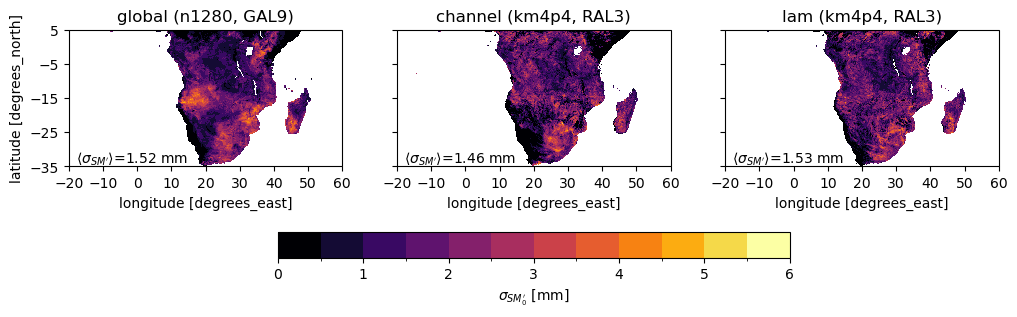

In [12]:
# Plot maps of high-frequency SM variability

cmap = plt.get_cmap('inferno')
bounds_ano = np.linspace(np.floor(std_ano_min), np.ceil(std_ano_max), 13)
norm_ano = BoundaryNorm(bounds_ano, cmap.N)

glo_std_mean = out_data_glo_ano_std.mean()
cha_std_mean = out_data_cha_ano_std.mean()
lam_std_mean = out_data_lam_ano_std.mean()


fig, ax = plt.subplots(ncols=3, subplot_kw={'projection': proj})

out_data_glo_ano_std.plot(ax=ax[0], norm=norm_ano, cmap=cmap, add_colorbar=False)
out_data_cha_ano_std.plot(ax=ax[1], norm=norm_ano, cmap=cmap, add_colorbar=False)
out_data_lam_ano_std.plot(ax=ax[2], norm=norm_ano, cmap=cmap, add_colorbar=False)

ax[0].text(xtxt, ytxt, "$\\langle \\sigma_{SM'} \\rangle$=%.2f mm"%glo_std_mean, transform=ax[0].transAxes)
ax[1].text(xtxt, ytxt, "$\\langle \\sigma_{SM'} \\rangle$=%.2f mm"%cha_std_mean, transform=ax[1].transAxes)
ax[2].text(xtxt, ytxt, "$\\langle \\sigma_{SM'} \\rangle$=%.2f mm"%lam_std_mean, transform=ax[2].transAxes)

ax[0].set_xticks(xtcks)
ax[0].set_yticks(ytcks)
ax[0].set_title('global (n1280, GAL9)')
ax[1].set_xticks(xtcks)
ax[1].set_yticks(ytcks)
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_title('channel (%s, %s)'%(resolution, physics))
ax[2].set_xticks(xtcks)
ax[2].set_yticks(ytcks)
ax[2].set_yticklabels([])
ax[2].set_ylabel('')
ax[2].set_title('lam (%s, %s)'%(resolution, physics))

cb = plt.colorbar(cm.ScalarMappable(norm=norm_ano, cmap=cmap), ax=ax[:], orientation='horizontal', label="$\\sigma_{SM_{%i}'}$ [mm]"%depth, shrink=0.55, pad=0.1)

fig.set_size_inches(12., 8.5)

#fig.suptitle('%s $-$ %s'%(driving, region), y=0.65)

fig.savefig(figfile_maps_var_ano)
figfile_maps_var_ano

In [13]:
# Get spatial mean and variability of daily values
out_data_glo_ = out_data_glo_d.stack(space=('latitude', 'longitude'))
out_data_cha_ = out_data_cha_d.stack(space=('latitude', 'longitude'))
out_data_lam_ = out_data_lam_d.stack(space=('latitude', 'longitude'))

out_data_glo_spat_mean = out_data_glo_.mean(dim='space')
out_data_glo_spat_std = out_data_glo_.std(dim='space')
out_data_cha_spat_mean = out_data_cha_.mean(dim='space')
out_data_cha_spat_std = out_data_cha_.std(dim='space')
out_data_lam_spat_mean = out_data_lam_.mean(dim='space')
out_data_lam_spat_std = out_data_lam_.std(dim='space')

# Get spatial averages of rolling mean values
out_data_glo_nd_time = out_glo_nd.stack(space=('latitude', 'longitude')).mean(dim='space')
out_data_cha_nd_time = out_cha_nd.stack(space=('latitude', 'longitude')).mean(dim='space')
out_data_lam_nd_time = out_lam_nd.stack(space=('latitude', 'longitude')).mean(dim='space')

# Get spatial averages of daily anomalies
out_data_glo_ano_ = out_glo_ano.stack(space=('latitude', 'longitude'))
out_data_cha_ano_ = out_cha_ano.stack(space=('latitude', 'longitude'))
out_data_lam_ano_ = out_lam_ano.stack(space=('latitude', 'longitude'))

out_data_glo_ano_spat_mean = out_data_glo_ano_.mean(dim='space')
out_data_glo_ano_spat_std = out_data_glo_ano_.std(dim='space')
out_data_cha_ano_spat_mean = out_data_cha_ano_.mean(dim='space')
out_data_cha_ano_spat_std = out_data_cha_ano_.std(dim='space')
out_data_lam_ano_spat_mean = out_data_lam_ano_.mean(dim='space')
out_data_lam_ano_spat_std = out_data_lam_ano_.std(dim='space')

/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/guicha/conda/envs/kscale/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


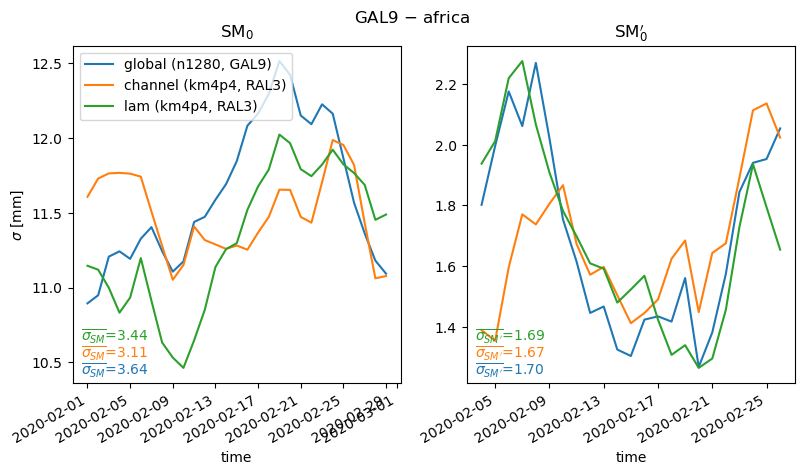

In [14]:
# Plot spatial variability of daily SM anomalies

fig, ax = plt.subplots(ncols=2)

plt.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.95)

p_glo = out_data_glo_spat_std.plot(ax=ax[0], label='global (n1280, GAL9)')
p_cha = out_data_cha_spat_std.plot(ax=ax[0], label='channel (%s, %s)'%(resolution, physics))
p_lam = out_data_lam_spat_std.plot(ax=ax[0], label='lam (%s, %s)'%(resolution, physics))

ax[0].text(0.025, 0.025, '$\overline{\\sigma_{SM}}$=%.2f'%out_data_glo_std.mean(), transform=ax[0].transAxes, c=p_glo[0].get_color())
ax[0].text(0.025, 0.075, '$\overline{\\sigma_{SM}}$=%.2f'%out_data_cha_std.mean(), transform=ax[0].transAxes, c=p_cha[0].get_color())
ax[0].text(0.025, 0.125, '$\overline{\\sigma_{SM}}$=%.2f'%out_data_lam_std.mean(), transform=ax[0].transAxes, c=p_lam[0].get_color())

out_data_glo_ano_spat_std.plot(ax=ax[1])
out_data_cha_ano_spat_std.plot(ax=ax[1])
out_data_lam_ano_spat_std.plot(ax=ax[1])

ax[1].text(0.025, 0.025, "$\overline{\\sigma_{SM'}}$=%.2f"%out_data_glo_ano_spat_std.mean(), transform=ax[1].transAxes, c=p_glo[0].get_color())
ax[1].text(0.025, 0.075, "$\overline{\\sigma_{SM'}}$=%.2f"%out_data_cha_ano_spat_std.mean(), transform=ax[1].transAxes, c=p_cha[0].get_color())
ax[1].text(0.025, 0.125, "$\overline{\\sigma_{SM'}}$=%.2f"%out_data_lam_ano_spat_std.mean(), transform=ax[1].transAxes, c=p_lam[0].get_color())

ax[0].set_ylabel('$\sigma$ [mm]')
ax[0].set_title('SM$_{%i}$'%depth)
ax[1].set_title("SM$_{%i}'$"%depth)
ax[1].set_ylabel('')

ax[0].legend(loc='upper left')

fig.suptitle('%s $-$ %s'%(driving, region)) #, y=1.05)
fig.set_size_inches(8.5, 4.5)

fig.savefig(figfile_spat_std)

'/home/users/guicha/Pythons/KSCALE/outputs/figures/africa/depth=0/timeseries.pdf'

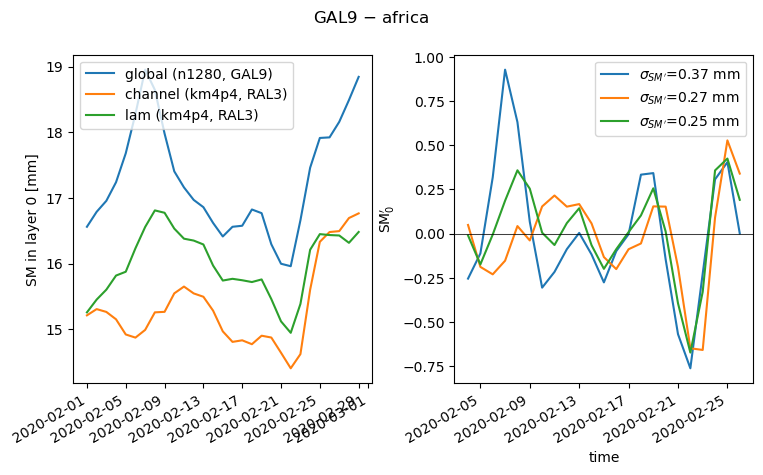

In [15]:
# Plot time series of domain-average SM (absolute values and anomalies)

glo_std = out_data_glo_ano_spat_mean.std()
cha_std = out_data_cha_ano_spat_mean.std()
lam_std = out_data_lam_ano_spat_mean.std()


fig, ax = plt.subplots(ncols=2)

plt.subplots_adjust(bottom=0.15, left=0.15, right=0.95, wspace=0.275)

p_glo = out_data_glo_spat_mean.plot(ax=ax[0], label='global (n1280, GAL9)')
p_cha = out_data_cha_spat_mean.plot(ax=ax[0], label='channel (%s, %s)'%(resolution, physics))
p_lam = out_data_lam_spat_mean.plot(ax=ax[0], label='lam (%s, %s)'%(resolution, physics))

out_data_glo_ano_spat_mean.plot(ax=ax[1], c=p_glo[0].get_color(), label="$\\sigma_{SM'}$=%.2f mm"%glo_std)
out_data_cha_ano_spat_mean.plot(ax=ax[1], c=p_cha[0].get_color(), label="$\\sigma_{SM'}$=%.2f mm"%cha_std)
out_data_lam_ano_spat_mean.plot(ax=ax[1], c=p_lam[0].get_color(), label="$\\sigma_{SM'}$=%.2f mm"%lam_std)

ax[1].axhline(0, 0, 1, c='k', lw=0.75, alpha=0.75)

ax[0].set_ylabel('SM in layer %i [mm]'%depth)
ax[0].set_title('')  # '%s $-$ %s'%(driving, region)
ax[0].set_xlabel('')
ax[1].set_ylabel("SM$_{%i}'$"%depth)
ax[1].set_title('')
ax[0].legend()
ax[1].legend()

fig.suptitle('%s $-$ %s'%(driving, region))
fig.set_size_inches(8.5, 4.5)

fig.savefig(figfile)
figfile

In [16]:
print('Done')

Done
